In [1]:
%load_ext autoreload
%autoreload 3 --log
%autoreload?

Docstring:
::

  %autoreload [-p] [-l] [--hide-errors] [mode]

%autoreload => Reload modules automatically

%autoreload or %autoreload now
Reload all modules (except those excluded by %aimport) automatically
now.

%autoreload 0 or %autoreload off
Disable automatic reloading.

%autoreload 1 or %autoreload explicit
Reload only modules imported with %aimport every time before executing
the Python code typed.

%autoreload 2 or %autoreload all
Reload all modules (except those excluded by %aimport) every time
before executing the Python code typed.

%autoreload 3 or %autoreload complete
Same as 2/all, but also but also adds any new objects in the module. See
unit test at IPython/extensions/tests/test_autoreload.py::test_autoload_newly_added_objects

The optional arguments --print and --log control display of autoreload activity. The default
is to act silently; --print (or -p) will print out the names of modules that are being
reloaded, and --log (or -l) outputs them to the log at INFO level.

In [2]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.set_default_device(device)
else:
    device = torch.device("cpu")
    torch.set_default_device(device)

torch.set_default_dtype(torch.float64)

print(f"Using device: {device}")

Using device: cuda


In [3]:
# Define model hyperparameters

from stpy.kernels import KernelFunction
from stpy.borel_set import BorelSet

gamma = 0.5
kappa = 1.0
d = 2
dt = 30
kernel = KernelFunction(
    kernel_name="squared_exponential", gamma=gamma, kappa=kappa, d=d
)
domain = BorelSet(d, bounds=torch.tensor([[-1.0, 1.0], [-1, 1]]).double())

In [4]:
# Define ground Truth Model

from stpy.point_processes.poisson.poisson import PoissonPointProcess
from validation import TruncatedGP

gp = TruncatedGP(kernel, d)
process = PoissonPointProcess(2, 1e6, 1e-6, gp, naive_integral=True)

In [5]:
from validation import check_approx_squared_integral_difference
from validation import plot_approximation

import numpy as np
from stpy.borel_set import HierarchicalBorelSets
from stpy.embeddings.triangle_base import EfficientTriangleEmbedding
from stpy.point_processes.poisson_rate_estimator import PoissonRateEstimator
from validation import plot_approximation

Optimal basis with arbitrary dimension, namely d = 2
Starting optimal basis construction, with m = 10
Optimal basis constructed.
Precomputation finished.
Sampling from the Ground Truth Poisson Process
Loading 195 Sampled Data points into approximate intensity model
nodes of functions torch.Size([10, 2])


/home/paul/semesterprojekt/.env/lib/python3.10/site-packages/cvxpy/reductions/solvers/conic_solvers/mosek_conif.py:654: UserWarning: 
Using MOSEK constants to specify parameters is deprecated.
Use generic string names instead.
For example, replace mosek.iparam.num_threads with 'MSK_IPAR_NUM_THREADS'

  warnings.warn(__MSK_ENUM_PARAM_DEPRECATION__, UserWarning)


Approximating the integral of the squared difference between the ground truth intensity and its approximation


Burn-In: 100%|██████████| 30/30 [00:02<00:00, 10.38it/s]
total number of velocity samples: 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1: 
sampling: 100%|██████████| 1/1 [00:00<00:00, 10.51it/s]
total number of velocity samples: 1: 


tensor(1.1399, device='cuda:0')


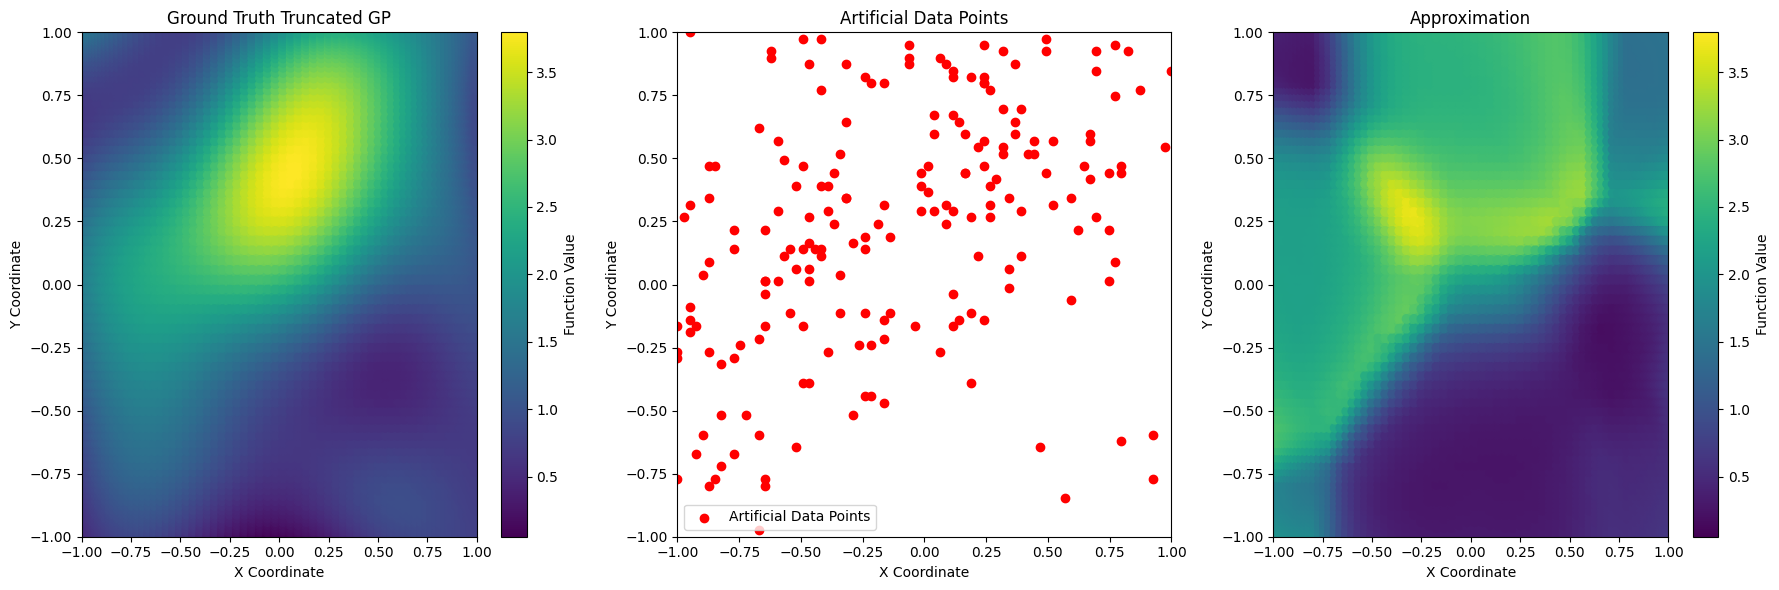

In [7]:
m = 10
min_intensity = 0.0
max_intensity = 1e7
offset = 0.1
jitter = 1e-7
estimator = PoissonRateEstimator(
    HierarchicalBorelSets(
        d=2, interval=[(-1, 1), (-1, 1)], levels=8
    ),  # 4^(8-1) cells in the lowest level
    d=2,
    kernel=kernel,
    max_intensity=max_intensity,  # maximal value of the rate function
    min_intensity=min_intensity,  # minimal value of the rate function
    basis_size_per_dim=m,  # number of basis functions along each axis
    langevine_sampling_steps=200,  # langevin steps for sampling
    optimization_library="cvxpy",
    use_anchors=False,
    basis="optimal-positive",
)
diff, dataset = check_approx_squared_integral_difference(
    process, estimator, domain, 80, 80, dt=dt, dataset=dataset if "dataset" in locals() else None
)
print(diff)
plot_approximation(process, estimator, domain, dataset)

Precomputation finished.
Loading 195 Sampled Data points into approximate intensity model
Approximating the integral of the squared difference between the ground truth intensity and its approximation


Burn-In: 100%|██████████| 30/30 [00:01<00:00, 18.15it/s]
total number of velocity samples: 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1: 
sampling: 100%|██████████| 1/1 [00:00<00:00, 13.43it/s]
total number of velocity samples: 1: 


tensor(0.5725, device='cuda:0')


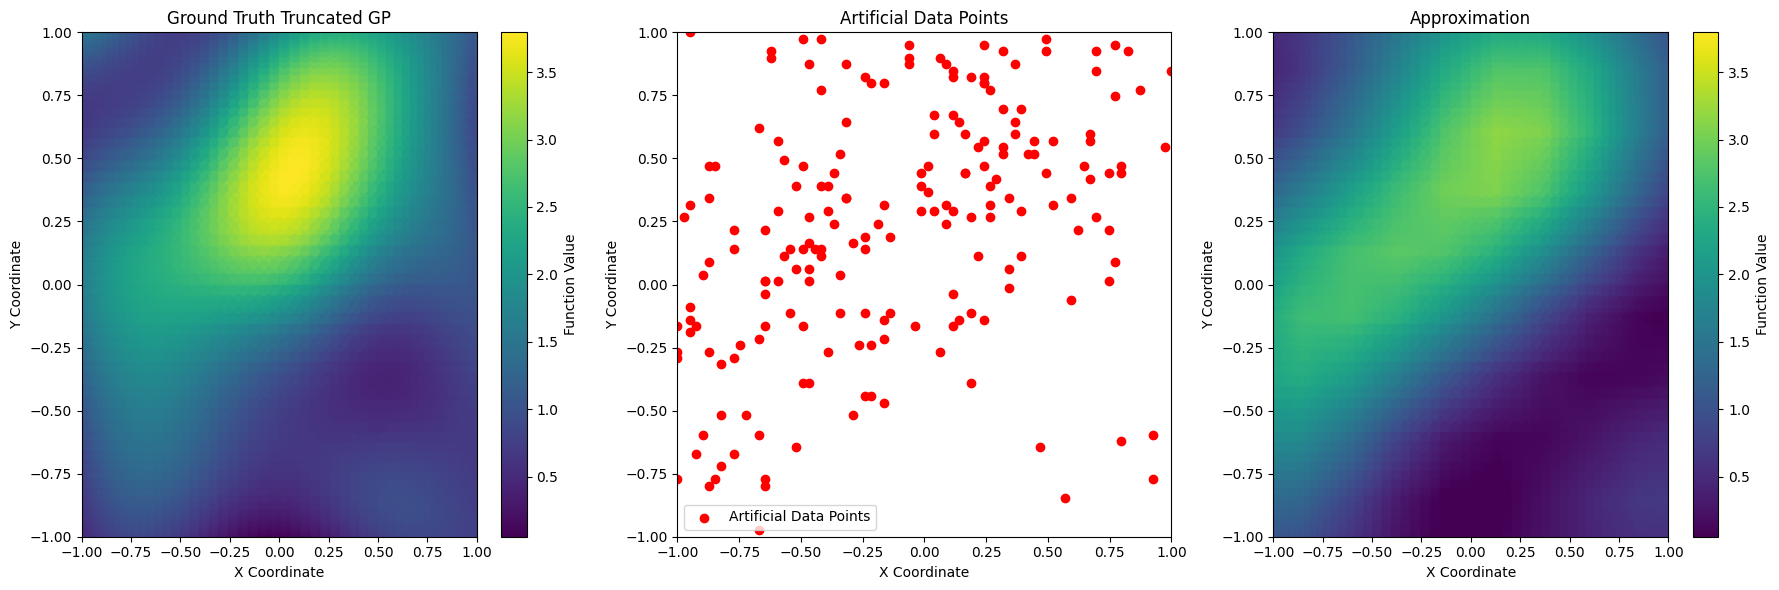

In [8]:
# Define a Triangle Base Estimator


m = 10
min_intensity = 0.0
max_intensity = 1e7
offset = 0.1
jitter = 1e-7
estimator = PoissonRateEstimator(
    HierarchicalBorelSets(
        d=2, interval=[(-1, 1), (-1, 1)], levels=8
    ),  # 4^(8-1) cells in the lowest level
    d=2,
    kernel=kernel,
    max_intensity=max_intensity,  # maximal value of the rate function
    min_intensity=min_intensity,  # minimal value of the rate function
    basis_size_per_dim=m,  # number of basis functions along each axis
    langevine_sampling_steps=200,  # langevin steps for sampling
    optimization_library="cvxpy",
    use_anchors=False,
    basis="custom",
    offset=offset,
    embedding=EfficientTriangleEmbedding(
        2,
        m,
        kernel_object=kernel,
        b=min_intensity,
        B=max_intensity,
        offset=offset,
        s=np.sqrt(jitter),
    ),
)

# Check the triangle base estimator
from validation import check_approx_squared_integral_difference

diff, dataset = check_approx_squared_integral_difference(
    process,
    estimator,
    domain,
    60,
    60,
    dt=dt,
    dataset=dataset if "dataset" in locals() else None,
)
print(diff)
plot_approximation(process, estimator, domain, dataset)

Loading 195 Sampled Data points into approximate intensity model


/home/paul/semesterprojekt/.env/lib/python3.10/site-packages/torch/utils/_device.py:106: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  return func(*args, **kwargs)


optimum found
Approximating the integral of the squared difference between the ground truth intensity and its approximation
tensor(0.6894, device='cuda:0')


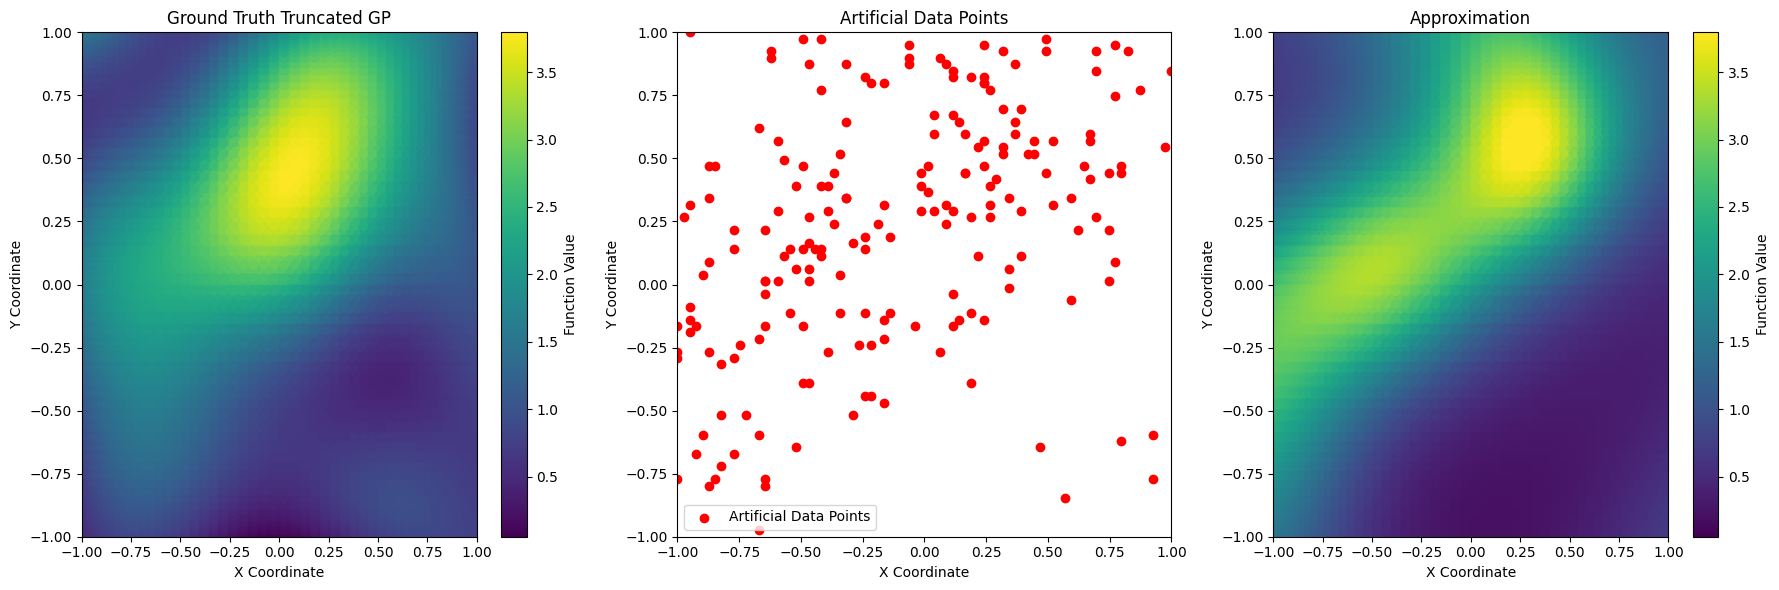

In [9]:
# Log Cox Process Check

from logcox_process import LogCoxProcess

estimator = LogCoxProcess(
    kernel, 60
)

diff, dataset = check_approx_squared_integral_difference(
    process,
    estimator,
    domain,
    60,
    60,
    dt=dt,
    dataset=dataset if "dataset" in locals() else None,
)
print(diff)
plot_approximation(process, estimator, domain, dataset)

In [10]:
function_values = estimator.rate_value(gp.x_acc, 1)
function_values.max()

tensor(3.9050, device='cuda:0')

[autoreload of logcox_process failed: Traceback (most recent call last):
  File "/home/paul/semesterprojekt/.env/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 274, in check
    superreload(m, reload, self.old_objects, self.shell)
  File "/home/paul/semesterprojekt/.env/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/home/paul/semesterprojekt/.env/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/home/paul/semesterprojekt/.env/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 365, in update_class
    update_instances(old, new)
  File "/home/paul/semesterprojekt/.env/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 323, in update_instances
    object.__setattr__(ref, "__class__", new)
TypeError: __class__ assignment only supported for mutable types or ModuleType subclasses
]

Precomputation finished.
Loading 195 Sampled Data points into approximate intensity model
Approximating the integral of the squared difference between the ground truth intensity and its approximation
tensor(0.6628, device='cuda:0')


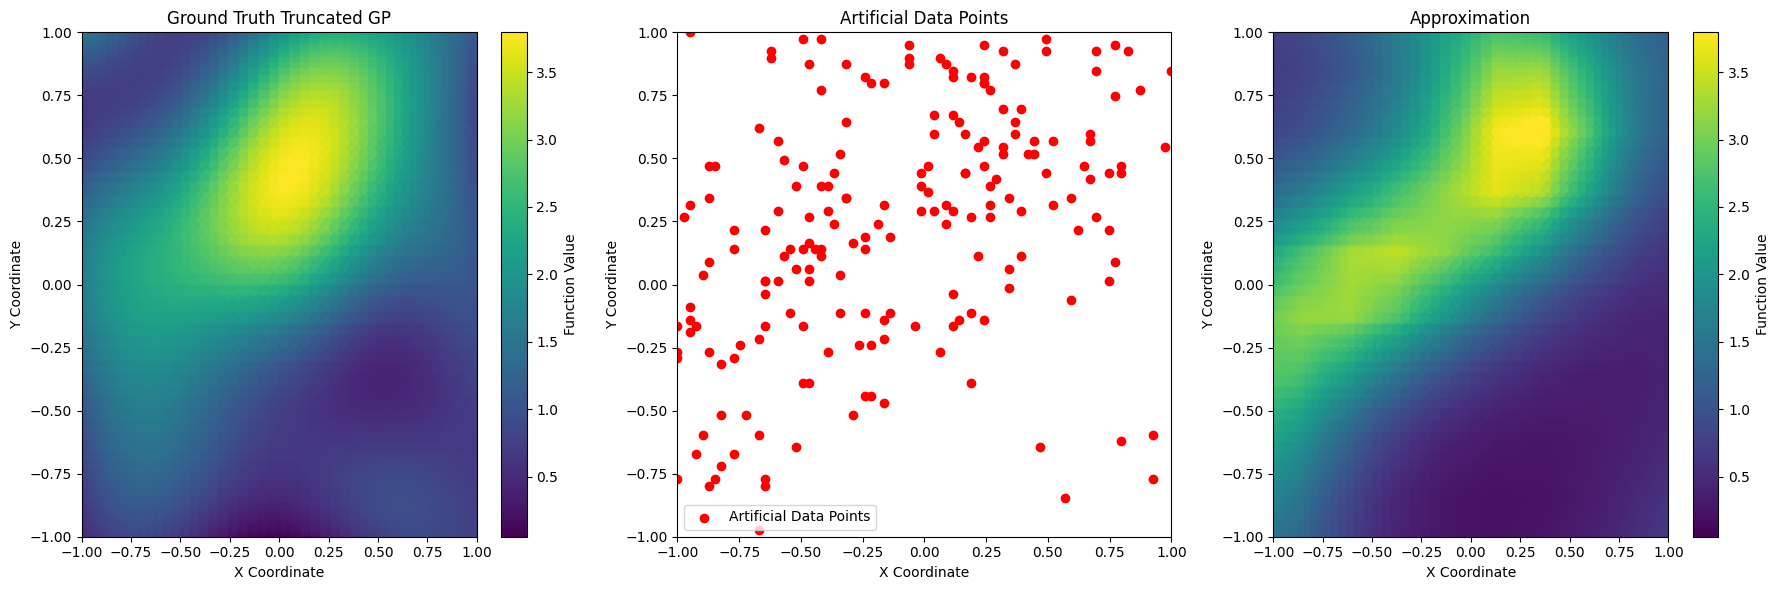

In [12]:
# Exponential GP with basis functions

from stpy.embeddings.optimal_positive_basis import OptimalPositiveBasis
from stpy.point_processes.link_fun_rate_estimator import ExpGaussProcessRateEstimator

m = 10
min_intensity = 1e-8
max_intensity = 1e8
offset = 0.1
jitter = 1e-7
estimator = ExpGaussProcessRateEstimator(
    HierarchicalBorelSets(
        d=2, interval=[(-1, 1), (-1, 1)], levels=5
    ),  # 4^(8-1) cells in the lowest level
    d=2,
    kernel=kernel,
    max_intensity=max_intensity,  # maximal value of the rate function
    min_intensity=min_intensity,  # minimal value of the rate function
    basis_size_per_dim=m,  # number of basis functions along each axis
    langevine_sampling_steps=200,  # langevin steps for sampling
    optimization_library="cvxpy",
    use_anchors=False,
    offset=offset,
    basis="custom",
    embedding=EfficientTriangleEmbedding(
        2,
        m,
        kernel_object=kernel,
        b=min_intensity,
        B=max_intensity,
        offset=offset,
        s=np.sqrt(jitter),
    ),
)
diff, dataset = check_approx_squared_integral_difference(
    process, estimator, domain, 80, 80, dt=dt , dataset=dataset
)
print(diff)
plot_approximation(process, estimator, domain, dataset)

Optimal basis with arbitrary dimension, namely d = 2
Starting optimal basis construction, with m = 10
Optimal basis constructed.
Precomputation finished.
Loading 195 Sampled Data points into approximate intensity model
nodes of functions torch.Size([10, 2])
Approximating the integral of the squared difference between the ground truth intensity and its approximation
tensor(0.9926, device='cuda:0')


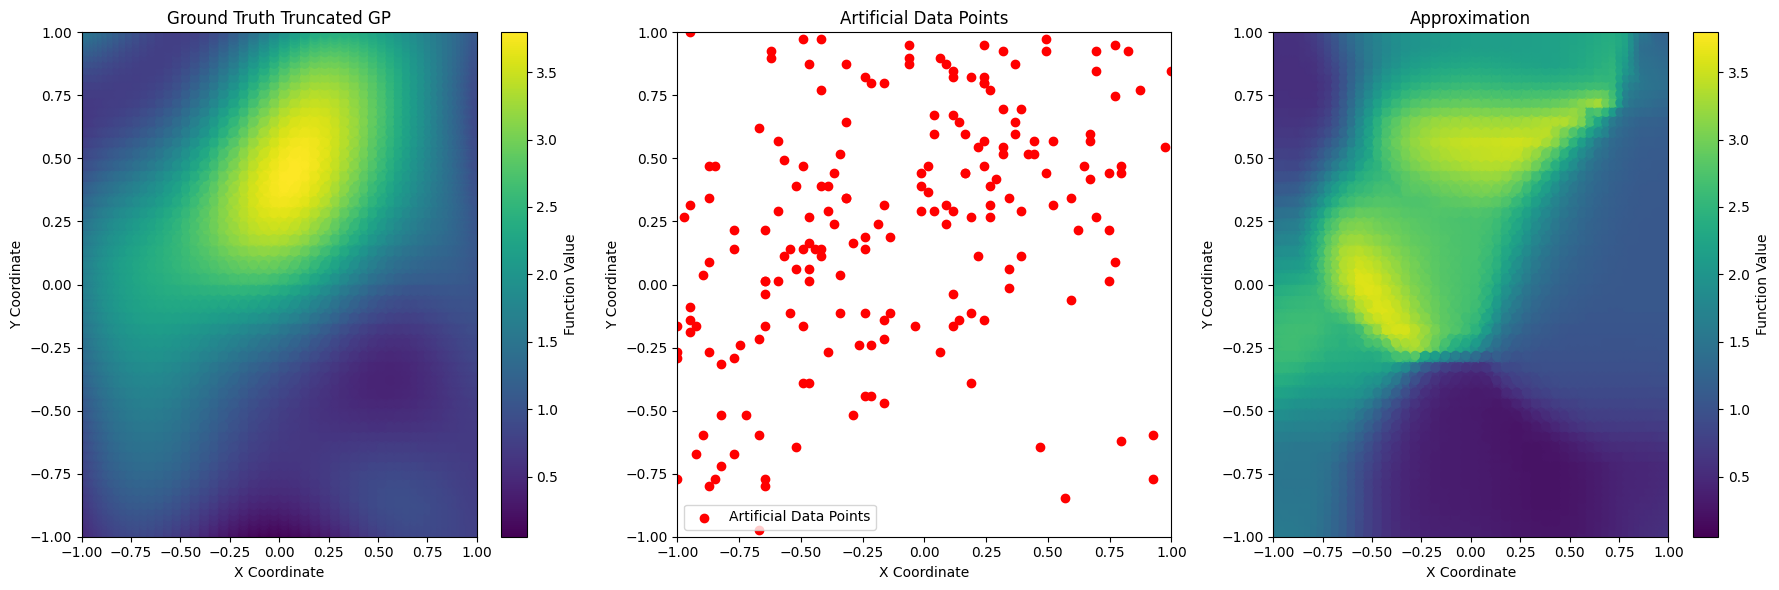

In [13]:
from stpy.point_processes.poisson_rate_estimator import PoissonRateEstimator

m = 10
min_intensity = 1e-8
max_intensity = 1e8
offset = 0.1
jitter = 1e-7
estimator = ExpGaussProcessRateEstimator(
    HierarchicalBorelSets(
        d=2, interval=[(-1, 1), (-1, 1)], levels=5
    ),  # 4^(8-1) cells in the lowest level
    d=2,
    kernel=kernel,
    max_intensity=max_intensity,  # maximal value of the rate function
    min_intensity=min_intensity,  # minimal value of the rate function
    basis_size_per_dim=m,  # number of basis functions along each axis
    langevine_sampling_steps=200,  # langevin steps for sampling
    optimization_library="cvxpy",
    use_anchors=False,
    basis="optimal-positive",
    offset=offset,
)


diff, dataset = check_approx_squared_integral_difference(
    process,
    estimator,
    domain,
    80,
    80,
    dt=dt,
    dataset=dataset if "dataset" in locals() else None,
)
print(diff)
plot_approximation(process, estimator, domain, dataset)

In [ ]:
# Create your own data to put ground truth model where you want it

x = torch.tensor([[0.5, 0.5], [-1, -1], [1, 1], [-1, 1], [1, -1]], dtype=torch.float64)
y = torch.tensor([2, 0, 0, 0, 0], dtype=torch.float64)
gp.gp.fit(x, y.unsqueeze(1))
gp.x_acc = x
gp.y_acc = y
# Create a grid of 50x50 that spans [-1, 1] in 2D
x = np.linspace(-1, 1, 20)
y = np.linspace(-1, 1, 20)
x, y = np.meshgrid(x, y)
grid_points = np.vstack([x.ravel(), y.ravel()]).T
grid_points = torch.tensor(grid_points, dtype=torch.float64)
grid_points.shape
sample = gp(grid_points, 1, burn_in=50)

Burn-In: 100%|██████████| 50/50 [00:01<00:00, 38.33it/s]
total number of velocity samples: 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1: 
sampling: 100%|██████████| 1/1 [00:00<00:00, 48.51it/s]
total number of velocity samples: 1: 
